# OneModel: an open-source SBML modeling tool focused on accessibility, simplicity and modularity

----

## WORKPLACE 00: Setup the Notebook

You MUST run the following two cells to be able to follow the exercises in the workshop.

1. Install OneModel package and setup the project structure.

In [10]:
# Install onemodel.
!pip install -I --no-cache-dir https://github.com/fernandonobel/onemodel/archive/jupyter.zip
    
# Install roadrunner for SBML simulations.
!pip install libroadrunner

# Install sbml2dae for generating MATLAB code.
!pip install sbml2dae

# Prepare folder structure for a OneModel project.
!mkdir src
!mkdir lib
!mkdir build
!mkdir solutions

     \ 5.2 MB 10.8 MB/s 0:00:00mm
  Installing build dependencies ... \^C
anceled
ERROR: Operation cancelled by user

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
mkdir: cannot create directory ‘src’: File exists
mkdir: cannot create directory ‘lib’: File exists
mkdir: cannot create directory ‘build’: File exists


2. Setup imports for Python and define a custom plotter for roadrunner.

In [1]:
import onemodel
import roadrunner

# Custom plot for roadrunner.
# Plots each state in a different plot.
def plot(rr):

    import pylab as p

    result = rr.getSimulationData()

    if result is None:
        raise Exception("no simulation result")

    # assume result is a standard numpy array

    selections = rr.timeCourseSelections

    if len(result.shape) != 2 or result.shape[1] != len(selections):
        raise Exception("simulation result columns not equal to number of selections,"
                        "likely a simulation has not been run")

    times = result[:,0]

    for i in range(1, len(selections)):
        series = result[:,i]
        name = selections[i]
            
        fig, ax = p.subplots()
        ax.plot(times, series, label=str(name))
        ax.legend()
        
# Add the custom plot to roadrunner.
roadrunner.RoadRunner.plot = plot

----

## WORKPLACE 01: The OneModel REPL (Read-Eval-Print Loop)

OneModel has an interactive command-line REPL (read-eval-print loop).

**Note:** use only single-line commands. To use a multiline command (i.e. a parameter block) you have to introduce manually intro lines using `;`.


```
# The REPL cannot handle block definitions.
parameter
  foo = 10
  bar = 20
end

# You would have to introduce the corresponding intros manually, using ';'
parameter; foo = 10; bar = 20; end

# Please use only single-line commands
parameter foo = 10
parameter bar = 20
```

In [2]:
# Execute the OneModel REPL (Read-Evaluate-Print Loop).
model = onemodel.shell()

# Export the model into SBML.
sbml = model.get_SBML_string()

# Print the defined model.
print("\n=== Built-in and user-defined variables =============\n")
print(model)

# Print the model exported into SBML.
print("\n=== SBML representation of the model ================\n")
print(sbml)

OneModel v1.0.0
Documentation: https://onemodel.readthedocs.io/

one> parameter k = 10
one> show(k)
Name        Value         Documentation
----------  ------------  ---------------
units       'per_second'
value       10
isConstant  True
__doc__     ''

one> k.value = 100
one> k.value
100
one> parameter k = 100
one> parameter k = 1 "This is my parameter"
one> k
<parameter value=1>
one> show(k)
Name        Value                   Documentation
----------  ----------------------  ---------------
units       'per_second'
value       1
isConstant  True
__doc__     'This is my parameter'

one> k.value = 100
one> k
<parameter value=100>
one> exit()

=== Built-in and user-defined variables =============

Name    Value                  Documentation
------  ---------------------  --------------------
k       <parameter value=100>  This is my parameter


----

## WORKPLACE 02: Define models using text

Instead of using the OneModel REPL, we can define models permanently using scripts.

In [9]:
# Define the model using a multi-line string.
text = """
model ProteinExpression
  species protein = 0
  parameter k = 1, d = 0.1
  reaction 
      0 -> protein ; k
      protein -> 0 ; d*protein
  end
end

model ProteinInduced
  extends ProteinExpression

  species TF = 0, k
  rule k := TF/(TF + 1)
end

A = ProteinInduced()
locals()
show(A)
"""

# Evalute the model.
model = onemodel.evaluate(text)

# Export the model into SBML.
sbml = model.get_SBML_string()

# Print the defined model.
print("\n=== Built-in and user-defined variables =============\n")
print(model)

# Print the model exported into SBML.
print("\n=== SBML representation of the model ================\n")
print(sbml)

Name               Value                                                          Documentation
-----------------  -------------------------------------------------------------  ---------------
A                  <object>
ProteinInduced     <model>
ProteinExpression  <model>
show               <builtin-function>
locals             <builtin-function>
globals            <builtin-function>
print              <builtin-function>
exit               <builtin-function>
__file__           '/home/nobel/Sync/projects/python/onemodel/examples/iwbda-22'
__exit__           False
__name__           '__main__'

Name     Value                                     Documentation
-------  ----------------------------------------  ---------------
_R2      <assignment-rule eq='k := TF/(TF + 1)'>
TF       <species initialConcentration=0>
_J1      <reaction eq='protein -> 0 ; d*protein'>
_J0      <reaction eq='0 -> protein ; k'>
d        <parameter value=0.1>
k        <species initialConcentration=0>
protein  

----

## WORKPLACE 03: How to edit files using Google Colab

Google Colab only allows to edit files with ".txt" or ".py" extensions. OneModel uses ".one" as extension, so to bypass this limitation we can use "%%writefile" to directly write text into a file.

We will use this special command to write files with OneModel syntax. 

While editing the contents of the following cell, use Ctrl+Intro to write into the file. You will see a message confirming that the file is written or overwritten.

In [79]:
%%writefile src/test_model.one

# Everything you write here will be saved into "test_model.one" when you press ctrl+intro or execute this cell.

species A = 1
species B = 0

parameter k = 1

reaction A -> B ; k*A

Overwriting src/test_model.one


We can read the contents of a file in two ways:

1. You can download the file from the left pane and open it localy with a text editor.
2. Or, you can just execute the following command to print the contents of the file.

In [80]:
# Print the contents of "test_model.one" when you press ctrl-intro or execute this cell.
%cat src/test_model.one


# Everything you write here will be saved into "test_model.one" when you press ctrl+intro or execute this cell.

species A = 0
species B = 0

parameter k = 1

reaction A -> B ; k*A


Now, we can use OneModel to directly read from the file `test_model.one` where we have defined our model.

----

## WORKPLACE 04: Define models using files

In [11]:
%%writefile src/my_model.one

species A = 10
species B = 0

parameter k = 0.1

reaction A -> B ; k*A

Overwriting src/my_model.one


The following cell loads the model from a file and runs a simulation using roadrunner.

Name    Value                              Documentation
------  ---------------------------------  ---------------
_J0     <reaction eq='A -> B ; k*A'>
k       <parameter value=1>
B       <species initialConcentration=2>
A       <species initialConcentration=10>


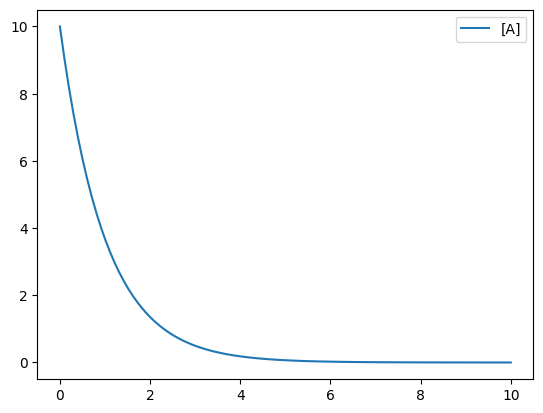

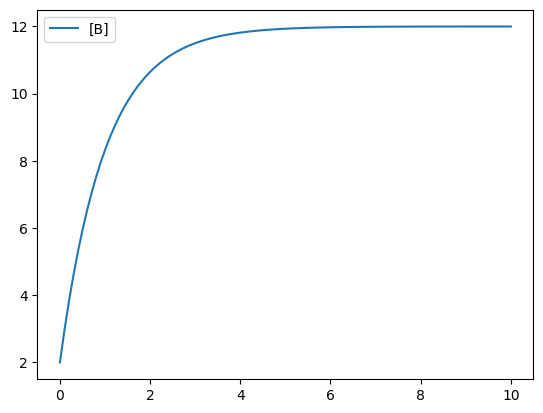

In [12]:
# Set the path where our model is located.
filepath = "src/my_model.one"

# Load the model.
model = onemodel.load(filepath)
print(model)

# Export the model into SBML.
sbml = model.get_SBML_string()

# Simulate the SBML and plot the results.
rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

The following commands allows you to generate a MATLAB implementation of the model. The generated MATLAB code is save in the ./build/ folder.

In [12]:
!onemodel export src/my_model.one
!sbml2dae export build/my_model.xml

### Convert sbml into matlab ###
	Extract DAE model from sbml model.
	Generated /home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/build/my_model_example.m
	Generated /home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/build/my_model.m


----

## WORKPLACE 05: `ProteinConstitutive`
$$\require{mhchem}$$ 
**Set of reactions:**

* mRNA transcription: $\ce{\emptyset->[k_m] mRNA}$
* mRNA degradation: $\ce{mRNA ->[d_m] \emptyset}$
* Protein translation: $\ce{mRNA ->[k_p] mRNA + protein}$
* Protein degradation: $\ce{protein ->[d_p] \emptyset}$

**Set of parameters:**

* Transcription rate: $k_m = 1$
* mRNA degradation rate: $d_m = 1$
* Translation rate: $k_p = 1$
* Protein degradation rate: $d_p = 1$

**Set of species:**

* Concentration of mRNA: $mRNA$
* Concentration of protein: $protein$

**Note:** You can check the documentation of the OneModel syntax to help your doing this exercie: https://onemodel.readthedocs.io/en/latest/onemodel_syntax.html 

In [43]:
%%writefile src/protein_constitutive.one

# TODO: Write your model here.


Overwriting src/protein_constitutive.one


Name                 Value     Documentation
-------------------  --------  ---------------
C                    <object>
B                    <object>
A                    <object>
ProteinConstitutive  <model>


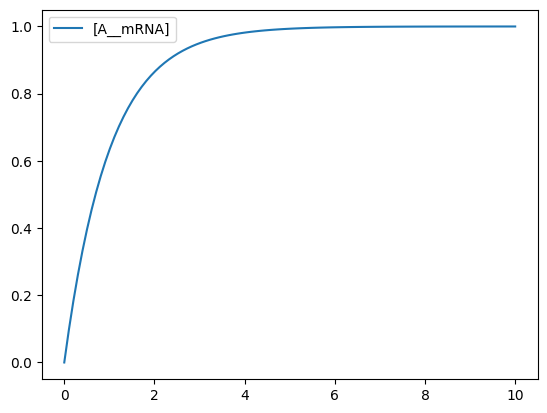

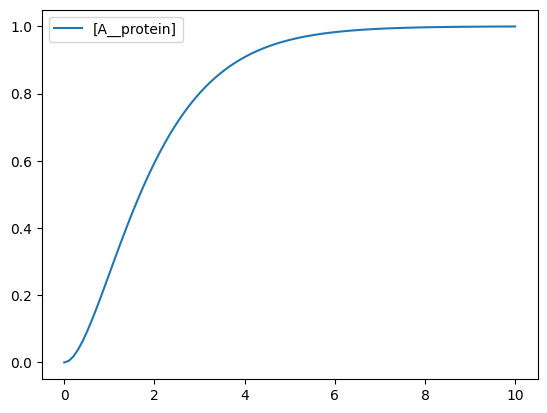

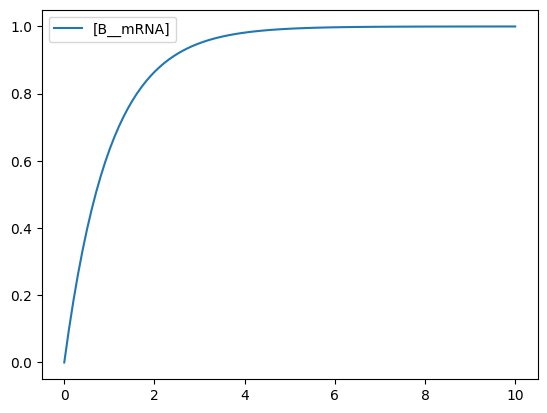

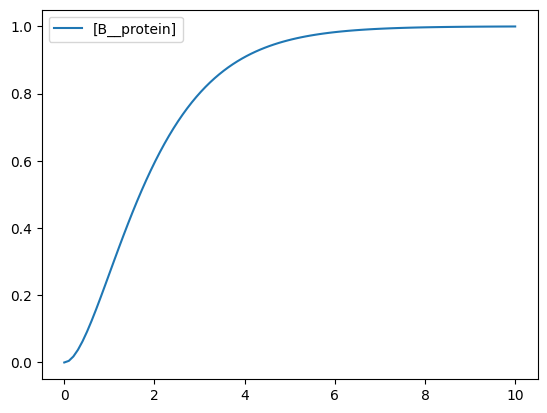

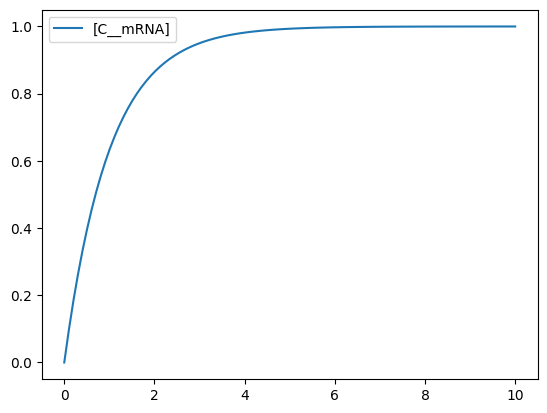

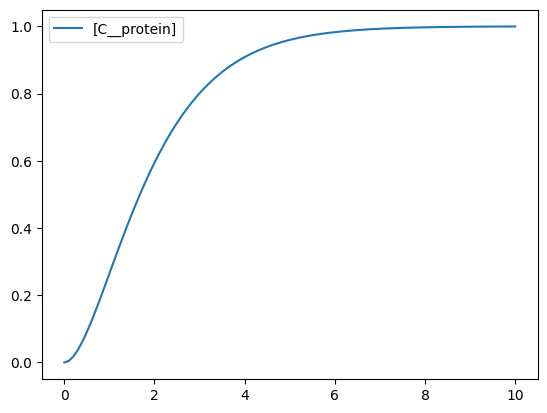

In [31]:
filepath = "src/protein_constitutive.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

----

## WORKPLACE 06: `ProteinInduced`

ProteinInduced makes the expression of a protein inducible by a transcription factor (TF).

The species you have to add are:

- $TF$: the transcription factor
- $k_m$: the trascrition rate has to be overriden to be a species (to make it able to change during simulation time)

The paratemer you have to add is:

- $h=1$: the half-activation threshold

You have to define the value of $k_m$ with a assignation rule:

- $k_m = \frac{TF}{(TF + h)}$ in onemodel syntax is `rule k_m := TF / (TF + h)`

Then, once that you have defined `ProteinInduced`, you have to define A as ProteinConstitutive and B as a ProteinInduced. And use the protein concentration of A as the transcription factor of B.

In [60]:
%%file src/protein_induced.one

# TODO: Write your model here.


Overwriting src/protein_induced.one


Name                 Value                                     Documentation
-------------------  ----------------------------------------  ---------------
_R9                  <assignment-rule eq='B.TF := A.protein'>
B                    <object>
A                    <object>
ProteinInduced       <model>
ProteinConstitutive  <model>


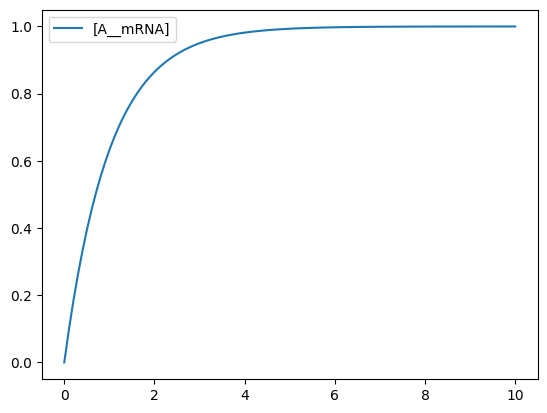

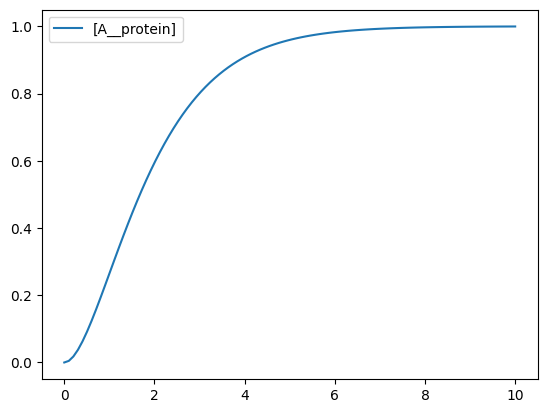

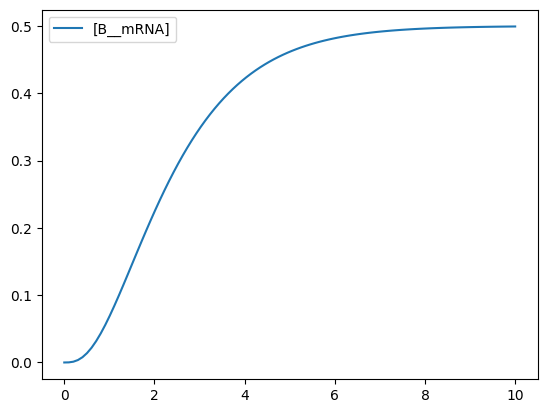

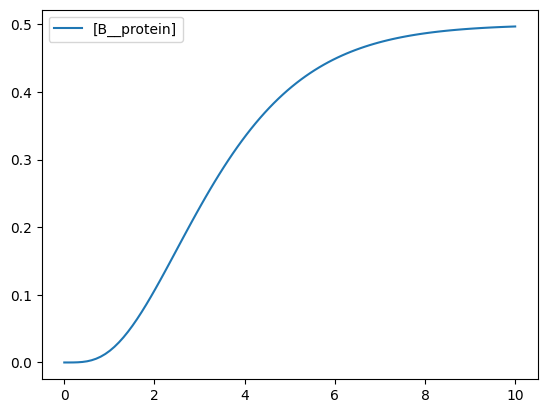

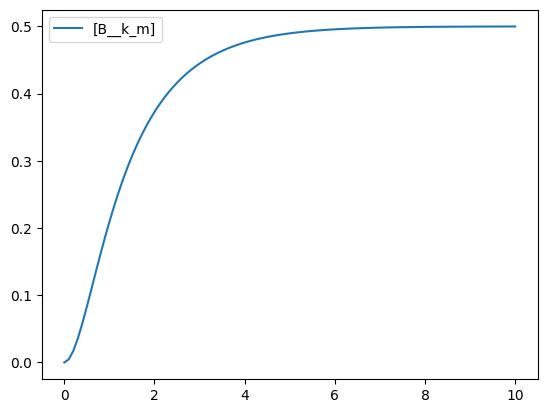

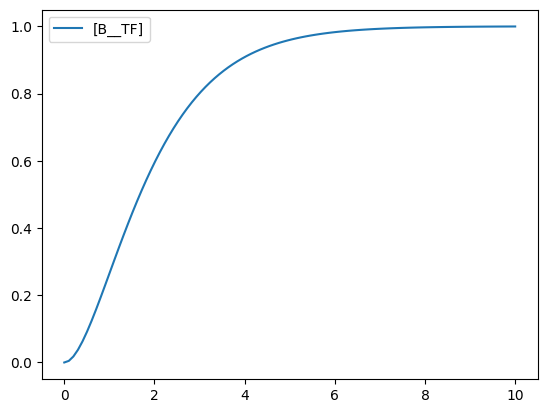

In [61]:
filepath = "src/protein_induced.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

----

## WORKPLACE 07: Antithetic Controller
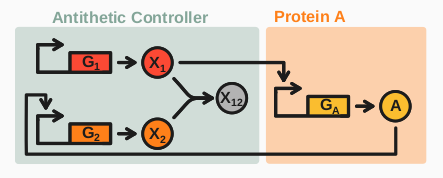

The idea is that:

- $x_1$ is a constitutively expressed protein (ProteinConstitutive)
- $x_2$ and $A$ are induced expressed proteins (ProteinInduced)

The transcription factor (TF) of $A$ is $x_1$, and the TF of $x_2$ is $A$. (You will need to use a rule for these).

Finally, $x_1$ and $x_2$ annihilate each other closing the loop. (You will need to add a reaction for this).

The annihilation rate is $\gamma = 1$

In [74]:
%%file src/antithetic_controller.one

# TODO: Write your model here.

from protein_constitutive import ProteinConstitutive
from protein_induced import ProteinInduced


Overwriting src/antithetic_controller.one


Name                 Value                                                                       Documentation
-------------------  --------------------------------------------------------------------------  ---------------
_J26                 <reaction eq='x1.protein + x2.protein -> 0 ; gamma*x1.protein*x2.protein'>
_R25                 <assignment-rule eq='x2.TF := A.protein'>
_R24                 <assignment-rule eq='A.TF := x1.protein'>
gamma                <parameter value=1>
A                    <object>
x2                   <object>
x1                   <object>
ProteinInduced       <model>
ProteinConstitutive  <model>


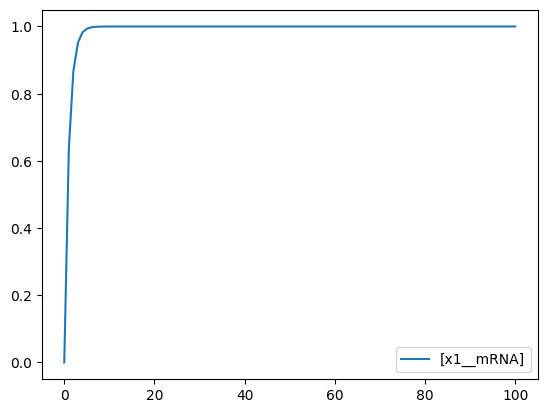

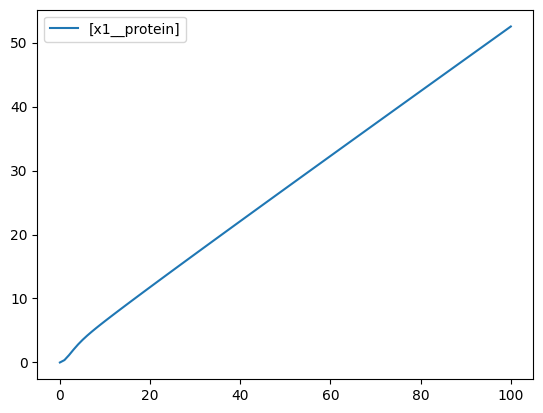

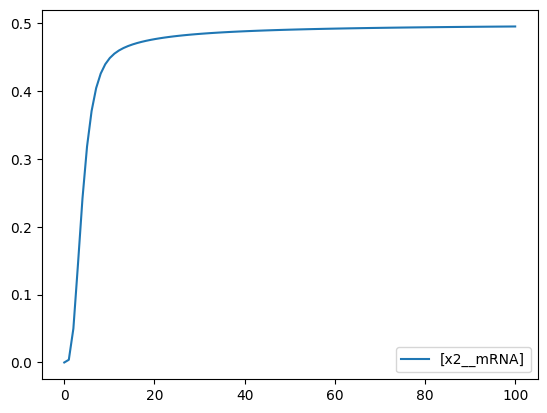

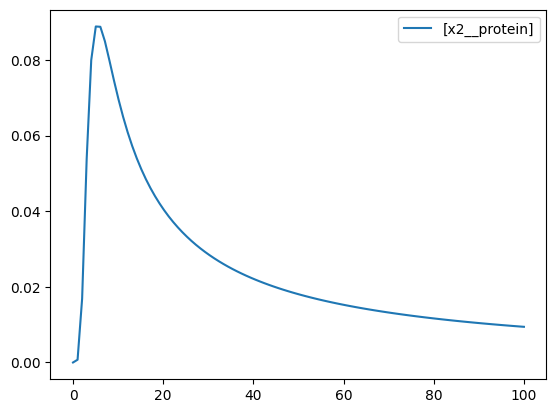

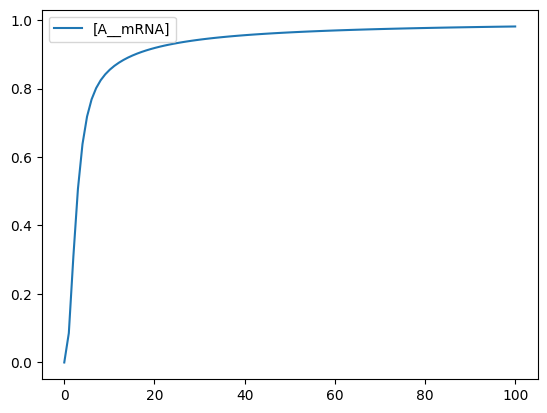

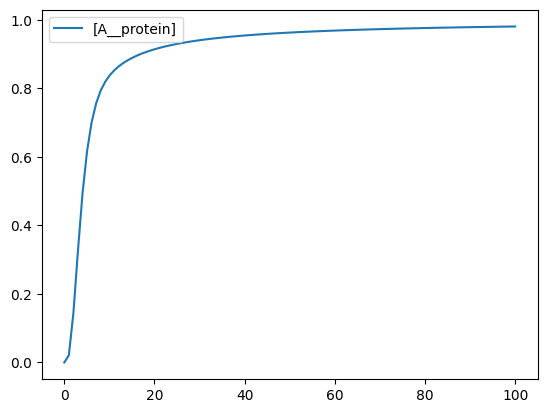

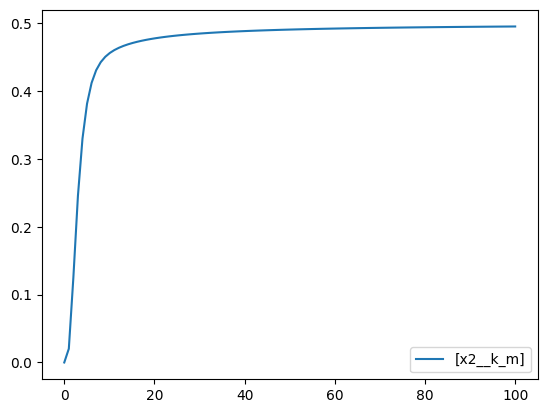

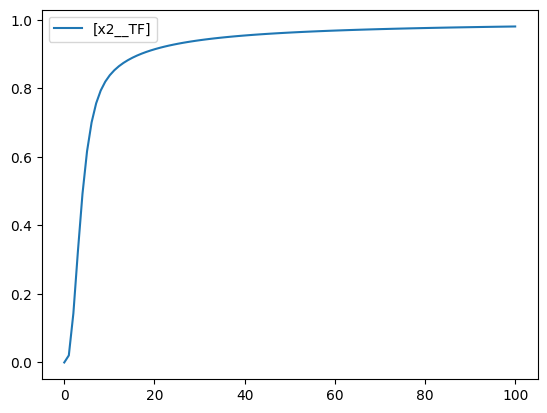

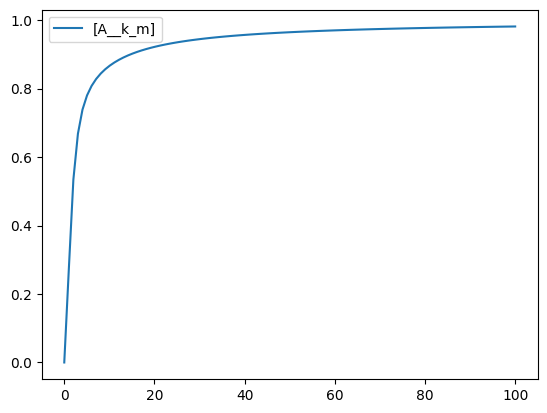

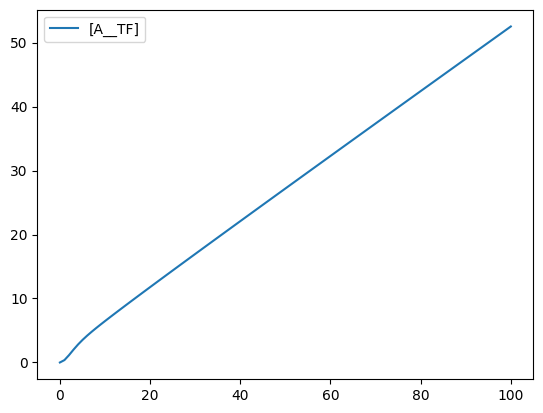

In [76]:
filepath = "src/antithetic_controller.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 100, 100) # (t_start, t_end, number_of_points)
rr.plot()

## WORKPLACE 08: Install dependencies

In [ ]:
%%file onemodel.toml

[dependencies]

protein_expression = "https://github.com/fernandonobel/protein_expression"

In [ ]:
onemodel.install_dependencies()

## WORKPLACE 09: Build models using pre-exisisting models

In [13]:
%%file src/antithetic_controller_2.one

from protein_expression.protein_constitutive import ProteinConstitutive
from protein_expression.protein_induced import ProteinInduced


Overwriting src/antithetic_controller_2.one


Name                 Value                                                                       Documentation
-------------------  --------------------------------------------------------------------------  ---------------
_J16                 <reaction eq='x1.protein + x2.protein -> 0 ; gamma*x1.protein*x2.protein'>
_R15                 <assignment-rule eq='x2.TF := A.protein'>
_R14                 <assignment-rule eq='A.TF := x1.protein'>
gamma                <parameter value=1>
A                    <object>
x2                   <object>
x1                   <object>
ProteinInduced       <model>
ProteinConstitutive  <model>
protein_expression   <module>


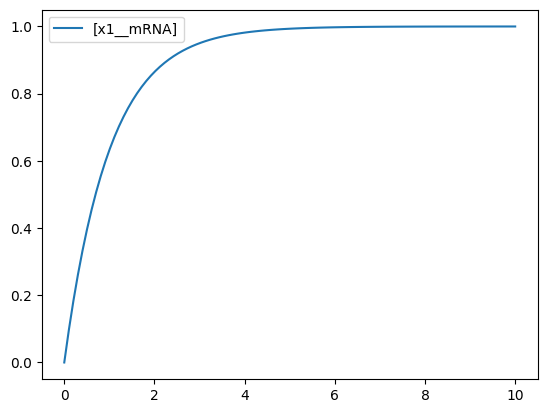

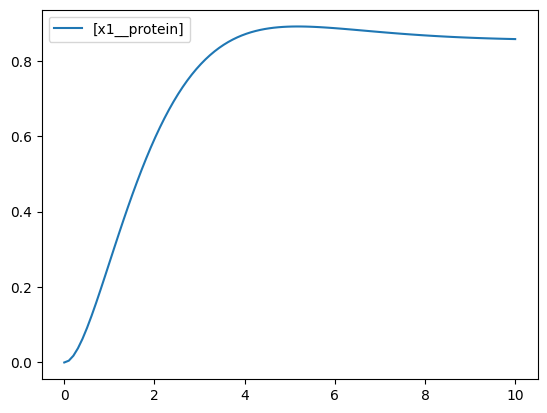

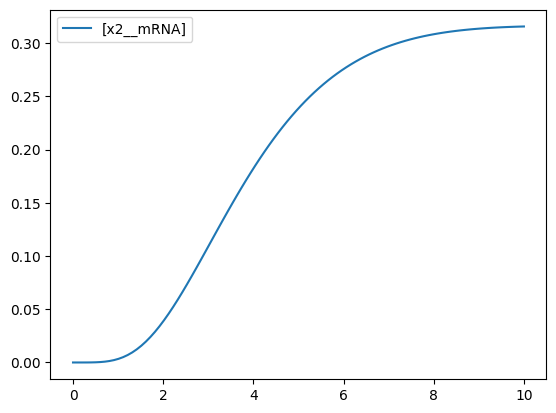

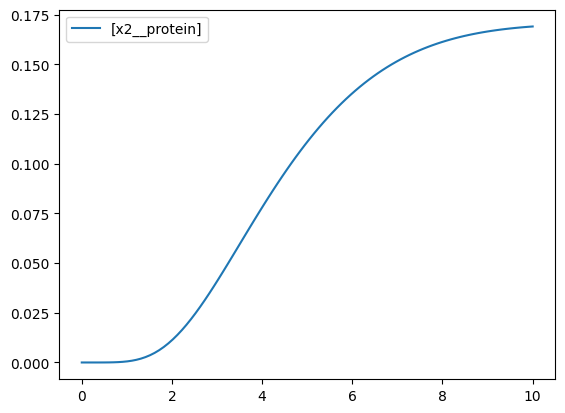

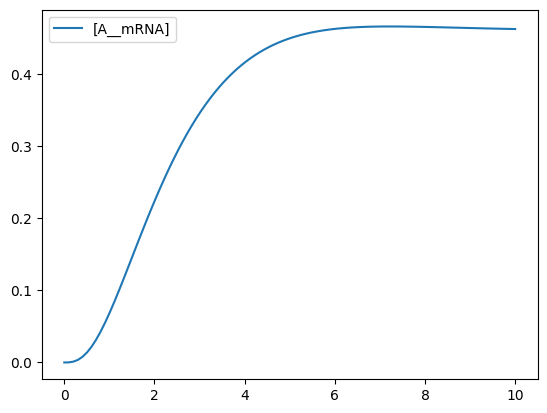

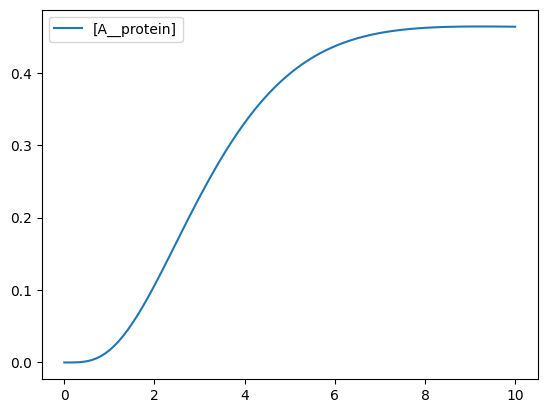

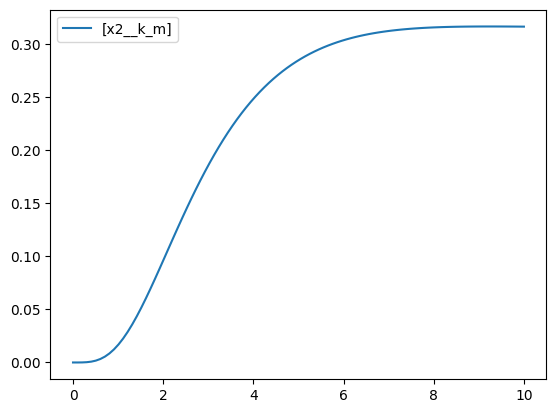

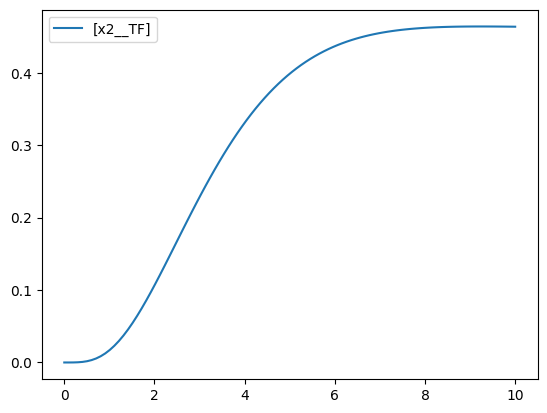

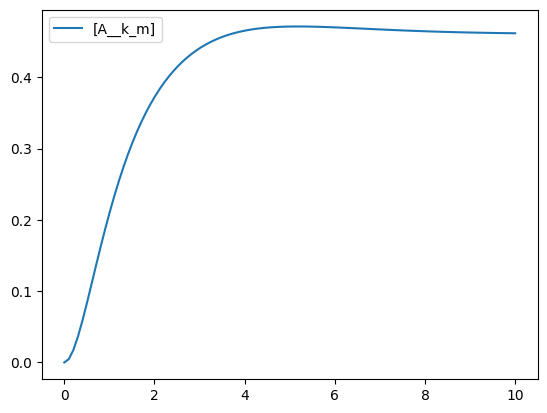

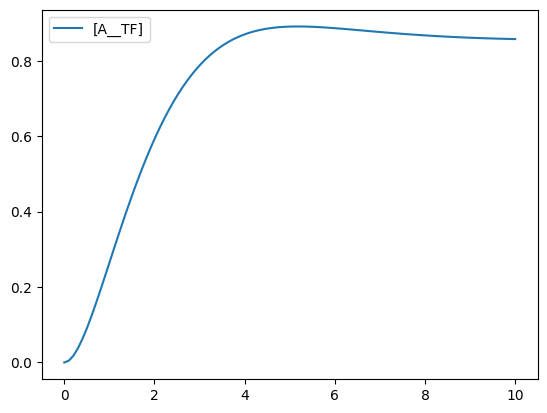

In [14]:
import onemodel

filepath = "src/antithetic_controller_2.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

## WORKPLACE 10: The host-aware model for *E. coli*

In [ ]:
%%file onemodel.toml

[dependencies]

protein_expression = "https://github.com/fernandonobel/protein_expression"
host_aware_model = "https://github.com/fernandonobel/host_aware_model"

In [ ]:
onemodel.install_dependencies()

In [ ]:
%%file src/host_aware_example.one

from host_aware_model.protein_constitutive import ProteinConstitutive
from host_aware_model.protein_ribosomal import ProteinRibosomal
from host_aware_model.protein_non_ribosomal import ProteinNonRibosomal
from host_aware_model.mass_equation import MassEquation

from host_aware_model.host_aware_model import HostAwareModel
from host_aware_model.mass_interpolated import MassInterpolated


cell = HostAwareModel()
mass = MassInterpolated()

parameter __t_end = 2000

# Define a constitutive expressed exogenous protein.
p_exo = ProteinConstitutive()

# Add protein A to the model.
rule
    p_exo.nu_t := cell.nu_t
    p_exo.mu := cell.mu
    p_exo.r := cell.r
    p_exo.m_h := cell.m_h
    p_exo.J_host_sum := cell.J_host_sum
end

# Override equations.
rule
    cell.WSum_equation:  WSum := p_r.W + p_nr.W + p_exo.W
    cell.m_p_equation:   m_p := p_r.m + p_nr.m + p_exo.m
end

rule 
    mass.mu := cell.mu
    cell.m_h := mass.m_h
end

In [ ]:
import onemodel

filepath = "src/host_aware_example.one"

model = onemodel.load(filepath)

print(model)

In [ ]:
!onemodel export src/host_aware_example.one
!sbml2dae export build/host_aware_example.xml